In [ ]:
'''
A/B-тестирование мобильных игр с помощью Cookie Cats
Аналитика клиентов и A/B-тестирование на Python

A/B-тестирование от Google: разработка и анализ онлайн-экспериментов

По мере прохождения игры игроки сталкиваются с воротами, которые заставляют их ждать некоторое время, 
прежде чем они смогут продвинуться вперед или совершить покупку в приложении. 
В этом проекте мы проанализируем результат A/B-теста, в котором первые ворота в Cookie Cats были перенесены 
с уровня 30 на уровень 40. В частности, мы проанализируем влияние на удержание игроков и игровые раунды.

Данные взяты из 90 189 игроков, которые установили игру во время проведения AB-теста. 

Переменные:

userid — уникальный номер, идентифицирующий каждого игрока.
version - попал ли игрок в контрольную группу (gate_30 - ворота 30 уровня) или тестовую группу (gate_40 - ворота 40 уровня).
sum_gamerounds — количество игровых раундов, сыгранных игроком в течение первой недели после установки
Retention_1 - плеер вернулся и поиграл через 1 день после установки?
Retention_7 - плеер вернулся и поиграл через 7 дней после установки?
Когда игрок устанавливал игру, ему или ей случайным образом присваивались gate_30 или gate_40.

Процесс AB-тестирования
Понимание бизнес-задач и данных
Обнаружение и устранение проблем в данных (отсутствующее значение, выбросы, непредвиденное значение)
Посмотрите сводную статистику и графики
Применяйте проверку гипотез и проверяйте предположения
Проверьте нормальность и однородность
Применить тесты (Шапиро, тест Левена, Т-тест, тест Уэлча, U-тест Манна-Уитни)
Оцените результаты
Делайте выводы
Рекомендовать бизнес-решение вашему клиенту/директору/генеральному директору и т. д.
'''

In [1]:
# Основные библиотеки

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Проверка гипотезы

from scipy.stats import shapiro
import scipy.stats as stats

# Конфигурация

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
path = "cookie_cats.csv"

def load(path, info = True):
    
    import pandas as pd
    import io
    
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)
    
    if info:
        if len(read) > 0:
            print("# Данные импортированы")
            print("# ------------------------------------", "\n")
        
            print("# РАЗМЕРЫ -------------------------")
            print("Наблюдение:", read.shape[0], "Колонки:", read.shape[1], "\n")
    
            print("# ТИПЫ ДАННЫХ -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Переменные object:", "\n", "# Переменых:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer переменные:", "\n", "# Переменных:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float переменные:", "\n", "# Переменных:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool переменные:", "\n", "# Переменных:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# ОТСУТСТВУЮЩЕЕ ЗНАЧЕНИЕ ---------------------")
            print("Есть ли пропущенные значения? \n ", np.where(read.isnull().values.any() == False, "Нет пропущенных значений!", "Данные включают пропущенное значение!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# ИСПОЛЬЗОВАНИЕ ПАМЯТИ ---------------------- \n", info)
          
        else:
            print("# Данные не импортированы!")
    
    return read
    
ab = load(path, info = True)
ab.head()

# Данные импортированы
# ------------------------------------ 

# РАЗМЕРЫ -------------------------
Наблюдение: 90189 Колонки: 5 

# ТИПЫ ДАННЫХ -----------------------------
Переменные object: 
 # Переменых: 1 
 ['version'] 

Integer переменные: 
 # Переменных: 2 
 ['userid', 'sum_gamerounds'] 

Bool переменные: 
 # Переменных: 2 
 ['retention_1', 'retention_7'] 

# ОТСУТСТВУЮЩЕЕ ЗНАЧЕНИЕ ---------------------
Есть ли пропущенные значения? 
  Нет пропущенных значений! 

# ИСПОЛЬЗОВАНИЕ ПАМЯТИ ---------------------- 
 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# Общая статистика: количество уникальных пользователей

print(ab.userid.nunique() == ab.shape[0])

# Общая статистика: sum_gamerounds

ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [4]:
# A/B группы и сводная статистика по группам gate_30 и gate_40
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


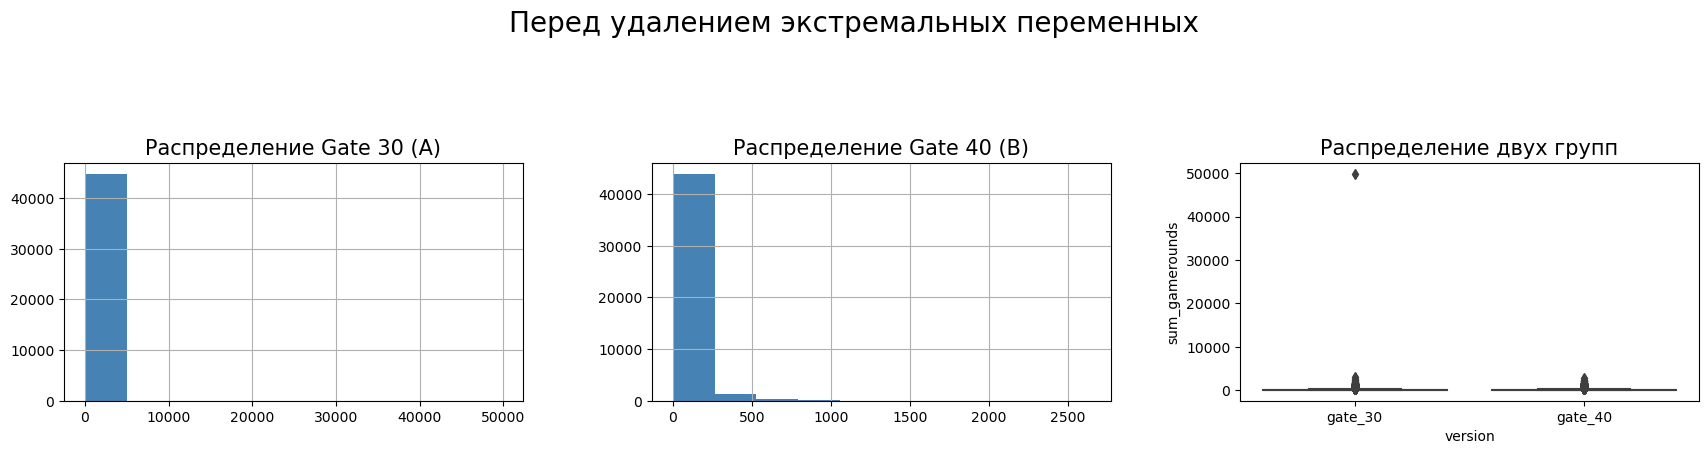

In [5]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[2])

plt.suptitle("Перед удалением экстремальных переменных", fontsize = 20)
axes[0].set_title("Распределение Gate 30 (A)", fontsize = 15)
axes[1].set_title("Распределение Gate 40 (B)", fontsize = 15)
axes[2].set_title("Распределение двух групп", fontsize = 15)

plt.tight_layout(pad = 4);

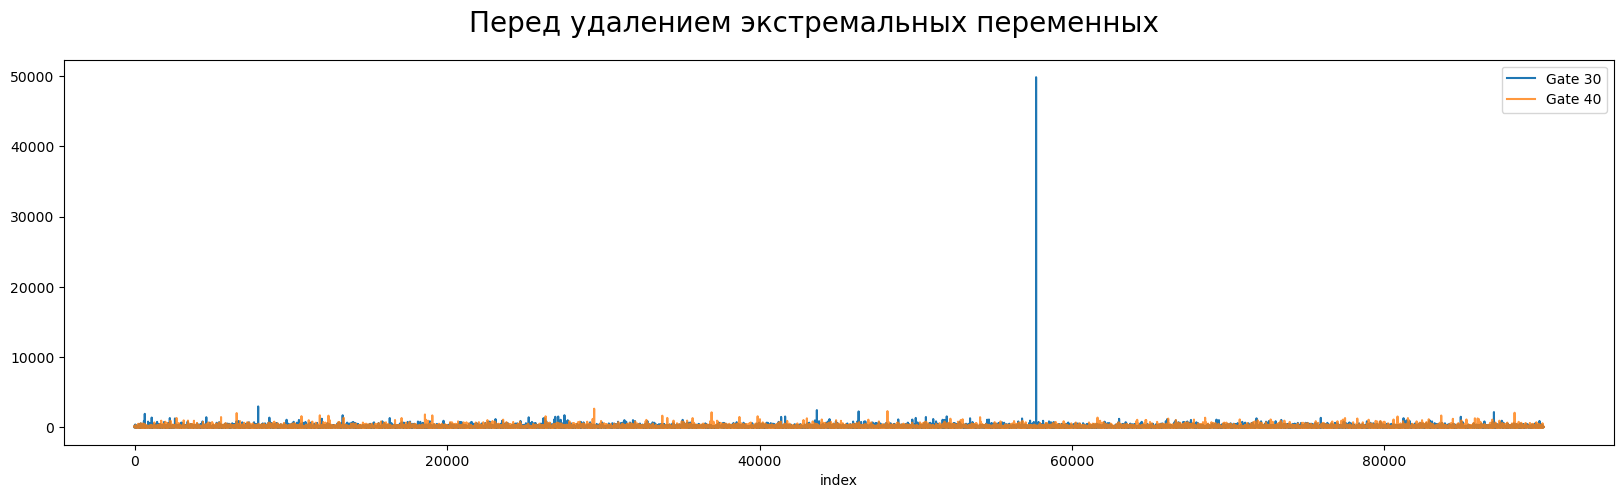

In [6]:
ab[(ab.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("Перед удалением экстремальных переменных", fontsize = 20);

In [7]:
# Выборки без экстремальных значений

ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Общая статистика: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


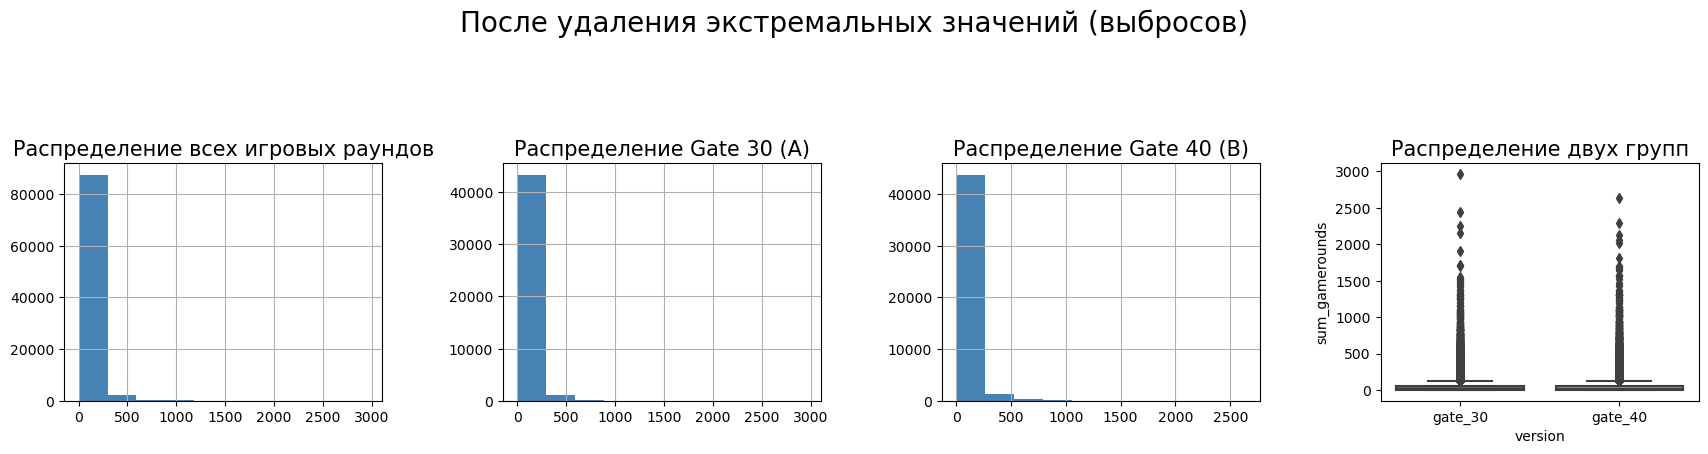

In [8]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
ab.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[3])

plt.suptitle("После удаления экстремальных значений (выбросов)", fontsize = 20)
axes[0].set_title("Распределение всех игровых раундов", fontsize = 15)
axes[1].set_title("Распределение Gate 30 (A)", fontsize = 15)
axes[2].set_title("Распределение Gate 40 (B)", fontsize = 15)
axes[3].set_title("Распределение двух групп", fontsize = 15)

plt.tight_layout(pad = 4);

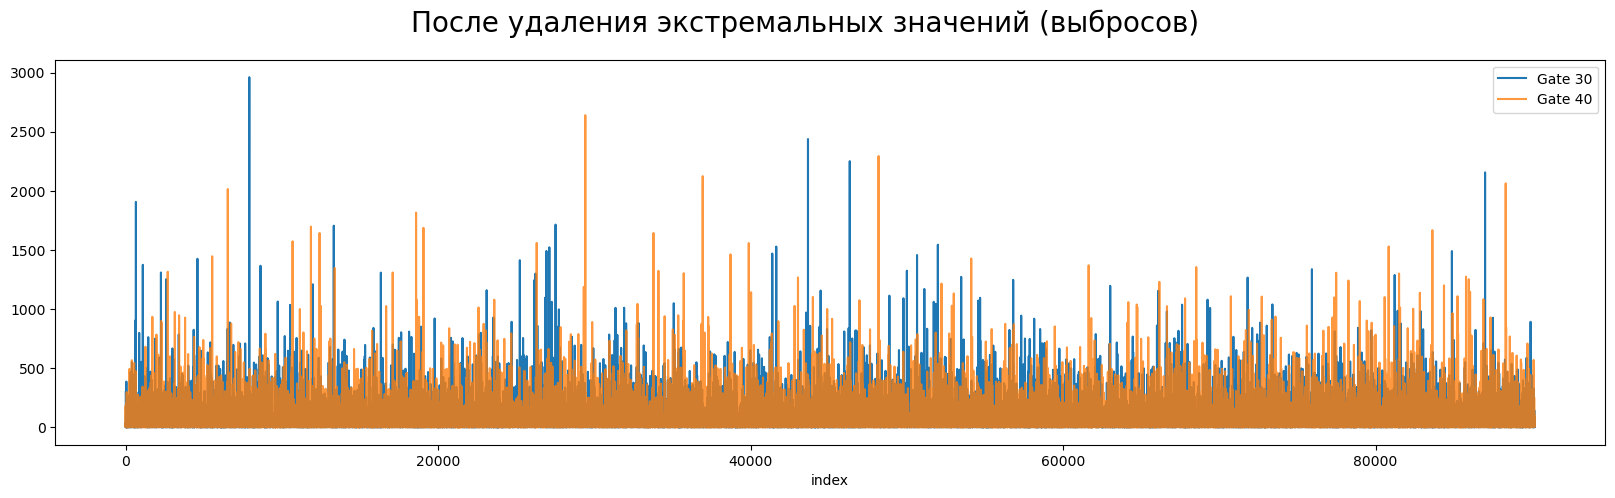

In [9]:
ab[(ab.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("После удаления экстремальных значений (выбросов)", fontsize = 20);

In [ ]:
'''
Пользователи установили игру, но 3994 пользователя так и не сыграли в нее! Некоторые причины:
(Рассчет будет ниже)

У них нет свободного времени, чтобы играть в игры
Пользователи могут предпочесть играть (или уже играют) в другие игры.
Некоторым пользователям не нравится приложение и т. д.

Количество пользователей уменьшается по мере прохождения уровней.
Большинство пользователей играли в игру на ранней стадии и не продвинулись вперед.

Компания Tactile Entertainment должна выяснить, почему пользователи отказываются от игры.
Проведение исследований и сбор данных об игре и пользователях помогут понять отток пользователей.
Сложность игры можно измерить
Подарки могут помочь удержать игроков
'''

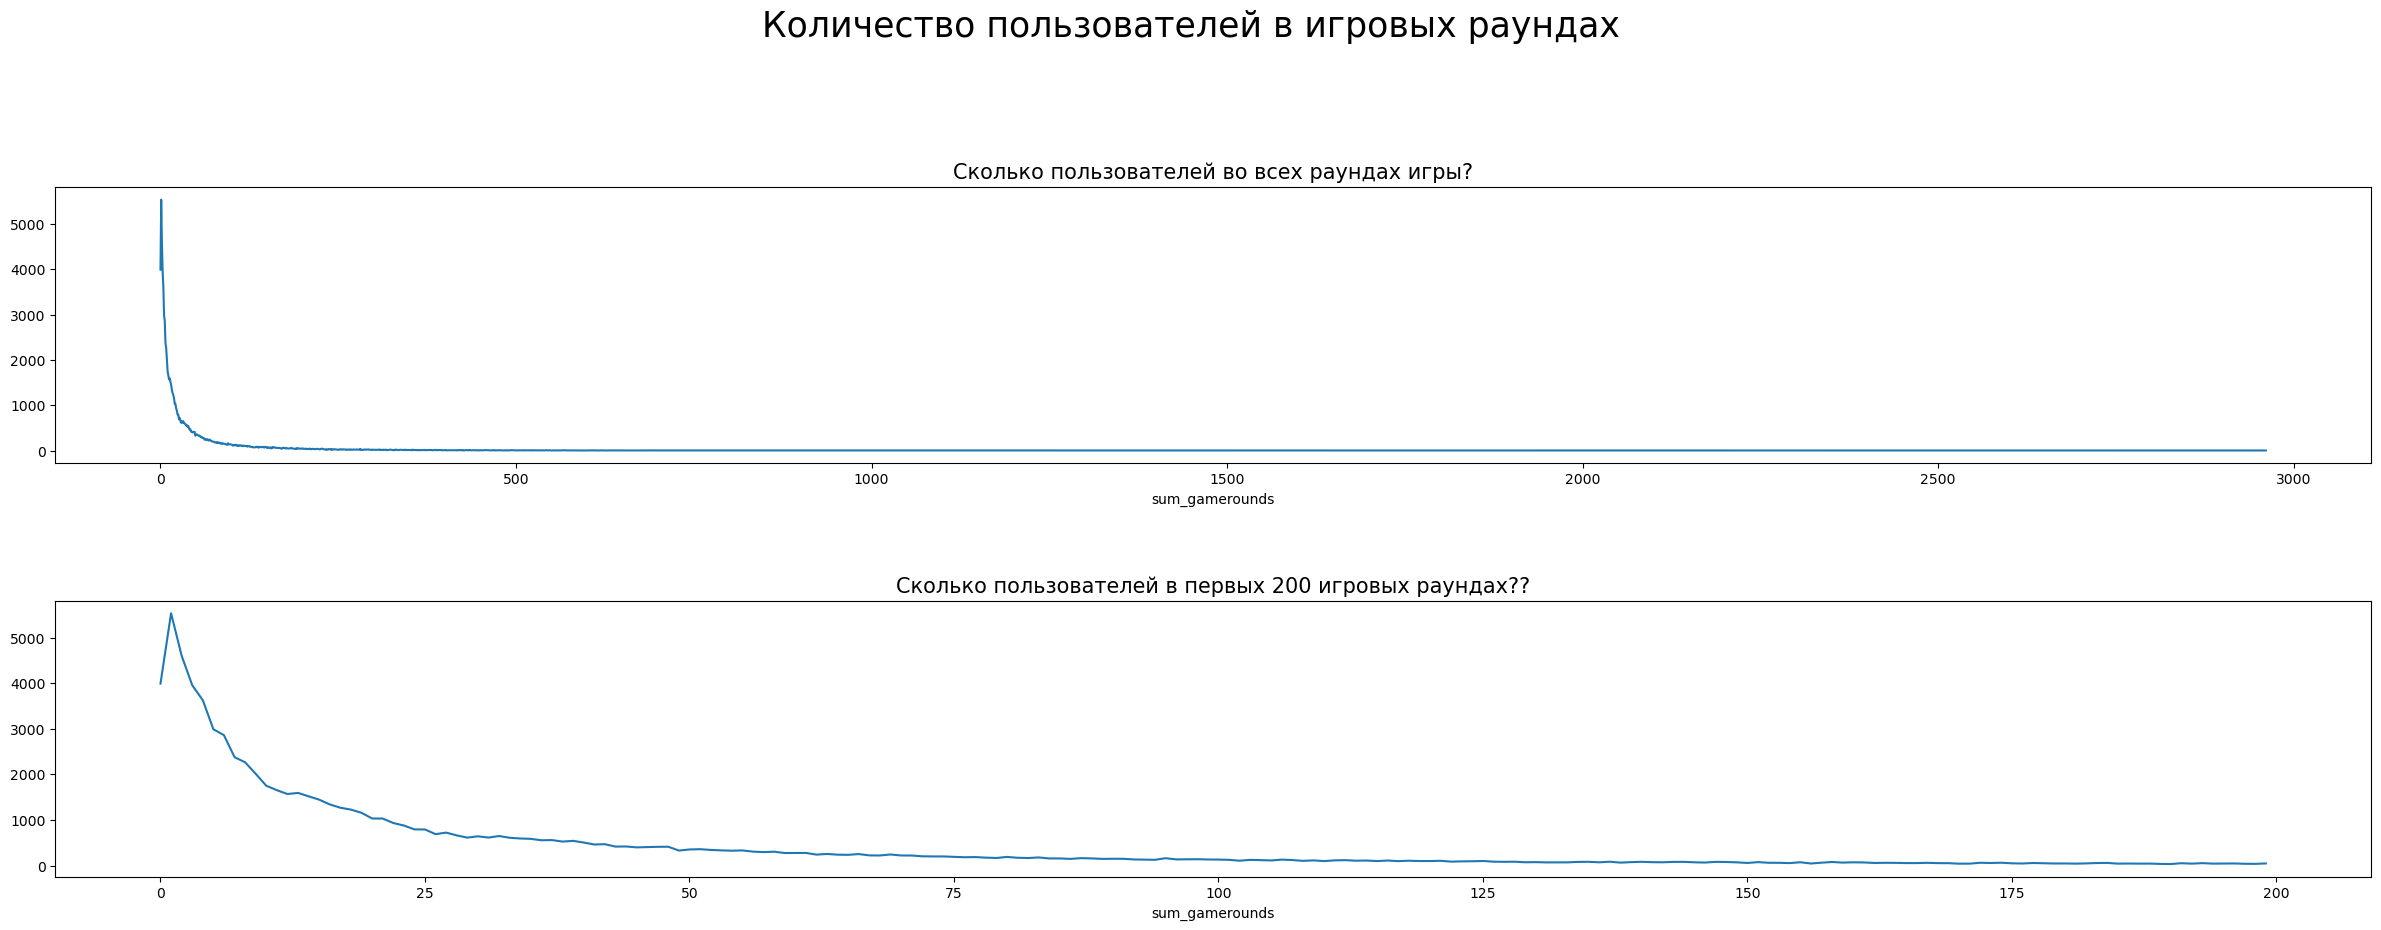

In [10]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
ab.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
ab.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("Количество пользователей в игровых раундах", fontsize = 25)
axes[0].set_title("Сколько пользователей во всех раундах игры?", fontsize = 15)
axes[1].set_title("Сколько пользователей в первых 200 игровых раундах??", fontsize = 15)
plt.tight_layout(pad=5)

In [11]:
ab.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [ ]:
'''
По индексу 0 те самые 3994 установивших, но не игравших пользователя. 
'''

In [12]:
# Сколько пользователей достигли уровней 30 и 40?

ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [ ]:
'''
Глядя на сводную статистику, контрольная и тестовая группы кажутся похожими, 
но являются ли эти две группы статистически значимыми?
'''

In [13]:
# A/B группы и сводная статистика.

ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


In [14]:
# Проблема удержания

pd.DataFrame({"RET1_COUNT": ab["retention_1"].value_counts(),
              "RET7_COUNT": ab["retention_7"].value_counts(),
              "RET1_RATIO": ab["retention_1"].value_counts() / len(ab),
              "RET7_RATIO": ab["retention_7"].value_counts() / len(ab)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


In [ ]:
Retention_1 - плеер вернулся и поиграл через 1 день после установки.
Retention_7 - плеер вернулся и поиграл через 7 дней после установки.
Также игроки склонны не играть в игру, и многие уходят из игры.

55 процентов игроков не играли в игру через 1 день после установки
81 процент игроков не играли в игру через 7 дней после установк

In [15]:
# Глядя на сводную статистику переменных по версиям и сравнивая их с sum_gamerounds,
# можно заметить сходство между группами. Посмотрим, существует ли статистически значимая разница.

ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [16]:
# И на 7ой день

ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version retention_7                                        
gate_30 False        36198  11.0000  25.7965  43.3162   981
        True          8501 105.0000 160.1175 179.3586  2961
gate_40 False        37210  11.0000  25.8564  44.4061  2640
        True          8279 111.0000 165.6498 183.7925  2294

In [17]:
ab["Retention"] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1,0)
ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

In [ ]:
'''
Примерно 13 000 пользователей из общего числа пользователей играли в игру как через 1 день, 
так и через 7 дней в двух группах. 
Предположительно, 14% от общего числа пользователей — это люди, которые продолжат игру в будущем.
'''

In [18]:
ab["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), ab.retention_1, ab.retention_7))
ab.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0000,11.8197,21.6426,981
1,gate_30,False-True,1825,43.0000,73.1693,93.2223,1072
2,gate_30,True-False,13358,33.0000,49.6945,58.1254,918
3,gate_30,True-True,6676,127.0000,183.8863,189.6264,2961
4,gate_40,False-False,23597,6.0000,11.9133,20.9010,547
5,gate_40,False-True,1773,47.0000,75.2611,94.4780,1241
6,gate_40,True-False,13613,32.0000,50.0255,60.9246,2640
7,gate_40,True-True,6506,133.0000,190.2824,194.2201,2294


In [ ]:
'''
Когда переменные удержания объединяются и сравниваются две группы, сводная статистика здесь также аналогична.
'''

In [ ]:
'''
A/B тестирование:

Проверим нормальность распределения.
Если распределение нормальное, проверьте однородность.
Шаги:
Разделить и определить контрольную группу и тестовую группу
Примените тест Шапиро на нормальность
Если параметрический параметр, примените тест Левена на однородность дисперсий.
Если параметрический + однородность отклонений применяется T-тест
Если параметрическая - однородность дисперсий, применить тест Уэлча
Если непараметрический вариант, примените U-критерий Манна-Уитни напрямую.
'''

In [19]:
# Разделим группы с помощью np.where

ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [26]:
# Пишем фунуцию для A/B теста

def AB_Test(dataframe, group, target):
    
    # Загружаем библиотеку
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Делим A/B группы
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Проверка нормальности методом Шапиро, альфа = 0.05
    
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Распределение нормально! - False
    # H1: Распределение не нормально! - True
    
    if (ntA == False) & (ntB == False): # "H0: Нормальное распределение"
        # Параметрический тест
        # Предположение: однородность дисперсий.
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Однородность: False
        # H1: Неоднородность: True
        
        if leveneTest == False:
            # Однородность
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Неоднородность
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Непараметрический тест (Манн-Уитни)
    
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Результат
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Параметрический", "Непараметрический")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Не отклоняем Н0", "Отклоняем H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Не удалось отклонить H0", "Группы A/B похожи!", "Группы A/B непохожи!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B тестирование гипотез")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Применим A/B тестирование

AB_Test(dataframe=ab, group = "version", target = "sum_gamerounds")

# A/B тестирование гипотез
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Непараметрический,Не отклоняем Н0,0.0509,Группы A/B непохожи!


In [ ]:
'''
После применения A/B-тестирования результат анализа дает нам важную информацию. Тестирование по Shapiro отклонило H0 
из-за предположения о нормальности. 
Поэтому нам нужно было применить непараметрический тест под названием Mann-Whitney U для сравнения двух групп. 
В результате U-теста Mann Whitney отвергла гипотезу H1, и мы узнали, что группы A/B непохожи.

Вкратце, между двумя группами, при исследовании методом Манна-Уиттни, существует очень слабая статистически значимая разница 
в перемещении первых ворот с уровня 30 на уровень 40 в игровых раундах. При этом значение p-value очень близко к пороговому.

Какой уровень имеет больше преимуществ с точки зрения удержания игроков?
Среднее удержание за 1 и 7 дней немного выше, когда ворота находятся на уровне 30, чем когда они находятся на уровне 40.
'''

In [24]:
ab.groupby("version").retention_1.mean(), ab.groupby("version").retention_7.mean()

(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64,
 version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)

In [ ]:
'''
Разница на 7 день составляет порядка 5%, что играет роль при большом количестве игроков и необходимости их (игроков) удержания.
Для более точного исследования требуется дополнительная информация.
'''